In [1]:
from int_green3d import *
from potential_initialization import *
import trimesh
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
mesh = trimesh.load_mesh("models/junction.stl")
nov, nof, nop = len(mesh.vertices), len(mesh.faces), len( trimesh.graph.connected_components(mesh.edges))
# faces and triagles are used interchangably

print("number of vertices: " + str(nov))
print("number of faces: " + str(nof))
print("number of connected parts: " + str(nop))

number of vertices: 1070
number of faces: 886
number of connected parts: 94


In [3]:
mesh.triangles

array([[[-1.28345478, -0.13998914,  0.002     ],
        [-1.28345478, -0.03499609,  0.002     ],
        [-0.96531206, -0.03499842,  0.002     ]],

       [[-1.28345478, -0.13998914,  0.002     ],
        [-0.96531206, -0.03499842,  0.002     ],
        [-0.94453752, -0.03749137,  0.002     ]],

       [[-0.14000277, -1.09998333,  0.002     ],
        [-0.035     , -0.99498332,  0.002     ],
        [ 0.14000277, -1.09998333,  0.002     ]],

       ...,

       [[-0.145     ,  0.64999998,  0.002     ],
        [-0.22536635,  0.64999998,  0.002     ],
        [-0.14535394,  1.14999998,  0.002     ]],

       [[ 0.22536635, -0.64999998,  0.002     ],
        [ 0.14535394, -1.14999998,  0.002     ],
        [ 0.145     , -0.64999998,  0.002     ]],

       [[ 0.22536635, -1.14999998,  0.002     ],
        [ 0.14535394, -1.14999998,  0.002     ],
        [ 0.22536635, -0.64999998,  0.002     ]]])

In [3]:
# index connected parts and label each vertex with its part's index.
label_vertices = trimesh.graph.connected_component_labels(mesh.edges)
label_triagles = [label_vertices[triagle[0]] for triagle in mesh.faces]

# a list of connected parts defined by their composite triagles
parts = [[] for i in range(nop)]
for idx, part_idx in enumerate(label_triagles):
    parts[part_idx].append(idx)

# indexing the vertices, faces and connected parts
coordinate2idx = dict()
triagle2idx = dict()
part2idx = dict()


def face_hash(face):
    '''
    return a hashable tuple that contains a small triagle's information.
    '''
    if face.shape == (3, ):
        return triagle2idx[tuple(sorted(face))]
    return triagle2idx[tuple(sorted([coordinate2idx[tuple(vertex)] for vertex in face]))]


for idx, vertex in enumerate(mesh.vertices):
    coordinate2idx[tuple(vertex)] = idx

for idx, face in enumerate(mesh.faces):
    triagle2idx[tuple(sorted(face))] = idx

for idx, part in enumerate(parts):
    part2idx[tuple(sorted(part))] = idx

In [4]:
from collections import defaultdict
idx2sector = [0, 0, 1, 4, 5, 8, 4, 8, 1, 5, 8, 4, 5, 1, 0, 0, 0, 0, 5, 8, 1, 4, 1, \
                        8, 4, 5, 0, 0, 0, 0, 8, 1, 5, 4, 5, 4, 8, 1, 7, 6, 3, 2, 4, 5, 8, 1, \
                        4, 5, 8, 1, 7, 2, 6, 3, 6, 3, 2, 7, 5, 4, 1, 8, 0, 0, 0, 0, 4, 5, 8, \
                        1, 3, 6, 2, 7, 5, 4, 1, 8, 6, 3, 2, 7, 0, 0, 6, 7, 3, 2, 0, 0, 0, 0, \
                        0, 0]
idx2sector = np.array(idx2sector)

idx2sector[[15, 17, 26, 16, 29, 14, 17, 28]] = 9

sector2idx = defaultdict(list)
for idx, sector in enumerate(idx2sector):
    sector2idx[sector].append(idx)

In [5]:
import display
%matplotlib qt
display.part(mesh, [13, 10])

In [6]:

comps = trimesh.graph.connected_components(mesh.edges)

criterion = dict()
criterion[1] = criterion[2] = lambda x: x[0] + x[1]
criterion[3] = criterion[4] = lambda x: -x[0] + x[1]
criterion[5] = criterion[6] = lambda x: -x[0] - x[1]
criterion[7] = criterion[8] = lambda x: x[0] - x[1]
sects = dict()
pairs = dict()

for sid in range(1, 9):
    crits = []
    for pid in sector2idx[sid]:
        nodes = comps[pid]
        vertices = np.array(mesh.vertices[nodes])
        indicator = np.array([criterion[sid](v) for v in vertices])
        arg = np.argmin(indicator)
        crits.append(indicator.min())
    
    arg = np.argsort(crits)
    # print(arg)
    sects[sid] = np.array(sector2idx[sid])[arg]

for idx, (e1, e8) in enumerate(zip(sects[1], sects[8])):
    pairs["R-%d" % idx] = (e1, e8)

for idx, (e2, e3) in enumerate(zip(sects[2], sects[3])):
    pairs["U-%d" % idx] = (e2, e3)

for idx, (e4, e5) in enumerate(zip(sects[4], sects[5])):
    pairs["L-%d" % idx] = (e4, e5)

for idx, (e6, e7) in enumerate(zip(sects[6], sects[7])):
    pairs["D-%d" % idx] = (e6, e7)

pairs['C-1'] = (14, 15)
pairs['C-2'] = (26, 28)
pairs['C-3'] = (29, 27)
pairs['C-4'] = (17, 16)

np.savez("models\junction", pairs=pairs, idx2sector=idx2sector, dc_sectors=[1, 2, 3, 4, 5, 6 ,7 ,8, 9])

In [7]:
a = np.ones(4)
list(a).append(0)

In [8]:
data = np.load("models\junction.npz", allow_pickle=True)
pairs = data["pairs"].item()
pair_names = list(pairs)
npairs = len(pairs)


In [9]:
import os
q = 1.6e-19
m = 0.171/6.02e23
omega_rf = 2 * np.pi * 30e6
V_rf = 170
PSCoef = (q / (4 * m * omega_rf ** 2)) * V_rf ** 2

%load_ext autoreload
%autoreload 2

shuttle_range = [[-1, 1], [-0.1, 0.1], [0.05, 0.1]]
# test of the function with sparse field points
field_points = get_field_points(shuttle_range)
field_points = np.transpose(field_points, (1, 2, 3, 0))
pb, pp = get_potential_basis("junction", PSCoef, field_points, regenerate=False)
pb.shape

TypeError: get_potential_basis() got multiple values for argument 'regenerate'

In [ ]:
pb, pp = get_potential_basis("junction", PSCoef, regenerate=False)
pb.shape, pp.shape

((400, 40, 10, 94), (400, 40, 10))

In [ ]:


voltage = np.random.uniform(-5, 5, size=94)
tp = get_total_potential(voltage, pb, pp)

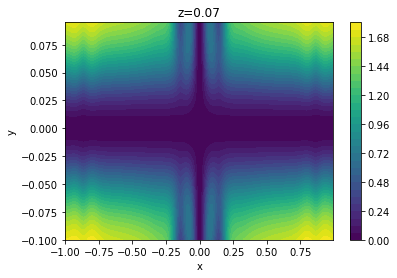

In [ ]:
import display 
%matplotlib inline 
voltage = np.zeros(nop)
slice = display.total_potential_slice(voltage, pb, pp, shuttle_range, 0.07)

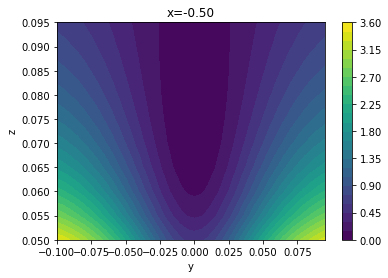

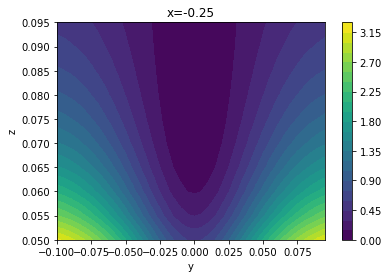

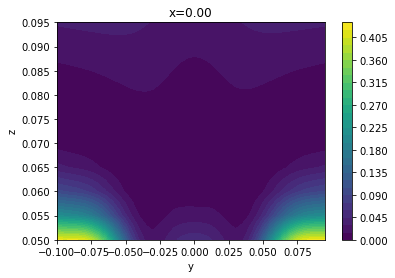

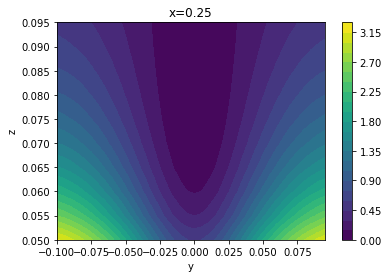

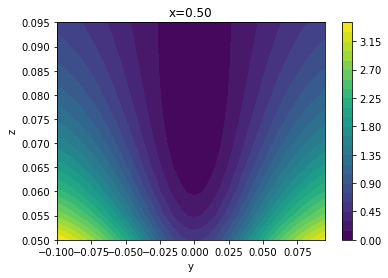

In [ ]:
for i in np.linspace(-0.5, 0.5, 5):
    display.potential_slicex(shuttle_range, i, pp)

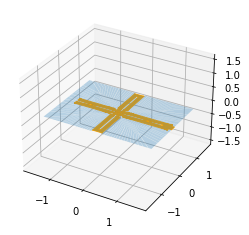

In [ ]:
display.part(mesh, 0)

In [ ]:
default_PSCoef = (q / (4 * m * omega_rf ** 2)) * V_rf ** 2
default_PSCoef

1.1453968088191449e-07

In [ ]:
get_charge_basis("junction", regenerate=True)

Calculating charge basis
(886, 3, 3)


array([[-4.15442989e+01,  7.21850415e+02, -1.01237253e+01, ...,
        -1.87941118e+01, -1.31063887e+01, -1.88579691e+01],
       [-1.32882374e+01,  1.96194021e+01, -2.64995459e+00, ...,
        -4.34978890e+00, -4.39892610e+00, -2.24330537e+00],
       [-1.09498429e-02, -2.25165142e-03, -4.33268867e-02, ...,
        -3.92824999e-02, -2.30159980e-02, -4.52102007e-02],
       ...,
       [-5.31823493e-03, -1.11497329e-03, -1.06193451e-02, ...,
         1.80541191e-03, -4.33850286e-03, -1.03336016e-02],
       [-7.60346195e-03, -1.65347714e-03, -1.05904230e-02, ...,
         4.19710202e+01, -4.08404985e-03, -1.00472872e-02],
       [-6.01155758e-03, -1.26268877e-03, -2.14010300e+00, ...,
        -3.93908849e-03,  4.18217000e+01,  3.92401207e+01]])

In [ ]:
# loading data from https://github.com/iontrapnet/BEM
import pandas as pd
import scipy.io

charge_basis = get_charge_basis("junction")

mat = scipy.io.loadmat('previous_data/chargebasis.mat')
mat["cb"].shape, charge_basis.shape
previous_triag = np.moveaxis(mat["triangles"], 2, 0)
previous_cb = np.moveaxis(mat["cb"], 0, 1)


csv=r'previous_data/nodes&parts.csv'
nn,ne=pd.read_csv(csv,header=None,nrows=1).to_numpy()[0]
df=pd.read_csv(csv,header=None,skiprows=1).to_numpy()
previous_parts = []
print(ne)
for i in range(ne):
    m = int(df[nn][0])
    set_of_triagles = [face_hash(triag) for triag in df[nn+1:nn+m+1]-1]
    previous_parts.append(set_of_triagles)
    nn += m+1

# Check if the indexing of parts is consistent with the previous definition
for idx, part in enumerate(previous_parts):
    assert part2idx[tuple(sorted(part))] == idx

# check if charge basis is correct
sorted(abs((charge_basis /  previous_cb).reshape(nof * nop) - 1), reverse=True)[:20]

94


[0.00949953945939197,
 0.008218999782153569,
 0.004151164546435937,
 0.0027556509759791847,
 0.0027241223121556857,
 0.001786374322391815,
 0.0015610899948818036,
 0.0012885440604523124,
 0.0012269548443171185,
 0.0007343633531174953,
 0.0007162992848532834,
 0.0006439705102333493,
 0.000637742654473028,
 0.000595261364232158,
 0.0004771680148052404,
 0.0003897818407210263,
 0.0003545406457563516,
 0.00026161098312349473,
 0.00023915452523226577,
 0.00014770038469369418]